In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io
import itertools

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset
import wandb

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
import data_analysis.visualization.publication as publication
import simulate
import two_points

import models as models
from models import MLP, CNN, ResNet

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
## Load settings
settings = "gain_1.6"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)
if nonlinearity == "discontinuous":
    nonlinearity = simulate.Discontinuous.apply
elif nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

mod = 1
# factor = 0.25
# n_epochs = int(factor * n_epochs)
# lr = lr / factor

# dy2 = 4
# dx2 = 9

In [3]:
## Generate data

input_dim, output_dim = 1, 1

# data, encoding = two_points.data_set(dx2, dy2, input_dim, output_dim, device)

inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
    input_dim
)
outputs = np.array([[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]) / np.sqrt(
    output_dim
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]
val_dataset = [data]

tracked_datasets = val_dataset + train_datasets

In [4]:
# ## Semantic data
# data_path = "../DNN/data/"

# properties = pd.read_csv(data_path + "amazing data/properties.txt", sep=" ", header=0)

# names = properties.columns.to_numpy()

# outputs = properties.to_numpy().T
# inputs = np.eye(len(names))

# encoding = OneHot(names)

# outputs = torch.from_numpy(outputs.astype(np.float32)).to(device)
# inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)

# dataset = TensorDataset(inputs, outputs)
# train_datasets = [dataset]
# val_dataset = [dataset]

# tracked_datasets = val_dataset + train_datasets

factor = 2
lr = lr / factor
n_epochs = n_epochs * factor

# mod = 100

In [5]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=input_dim,
    output_size=output_dim,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=nonlinearity,
)

In [20]:
## Setup compiler

# Define Loss, Optimizer
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][hidden_layer], datasets=tracked_datasets
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=tracked_datasets
    ),
}

In [21]:
input_1 = train_datasets[0][0][0]
input_2 = train_datasets[0][1][0]
pred_1 = model(input_1)[0]
pred_2 = model(input_2)[0]
input_1, input_2, pred_1, pred_2 = [
    a.detach().numpy() for a in (input_1, input_2, pred_1, pred_2)
]

G = np.linalg.norm(pred_2 - pred_1) ** 2 / np.linalg.norm(input_2 - input_1) ** 2
print(f"Overall gain: {G:.3e}, predicting {'rich' if (G < 1) else 'lazy'} learning!")

Overall gain: 3.928e+00, predicting lazy learning!


In [22]:
## Training run
compiler.training_run(
    train_datasets,
    tracked_datasets,
    n_epochs=n_epochs,
    batch_size=100,
)

Training: 100%|██████████| 6000/6000 [02:29<00:00, 40.14steps/s, train_loss=0.02220, val_loss=0.02220]


/home/loek/projects/rnn/DNN/../source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'A' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  label.loc[index] = index
/home/loek/projects/rnn/DNN/../source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  label.loc[index] = index


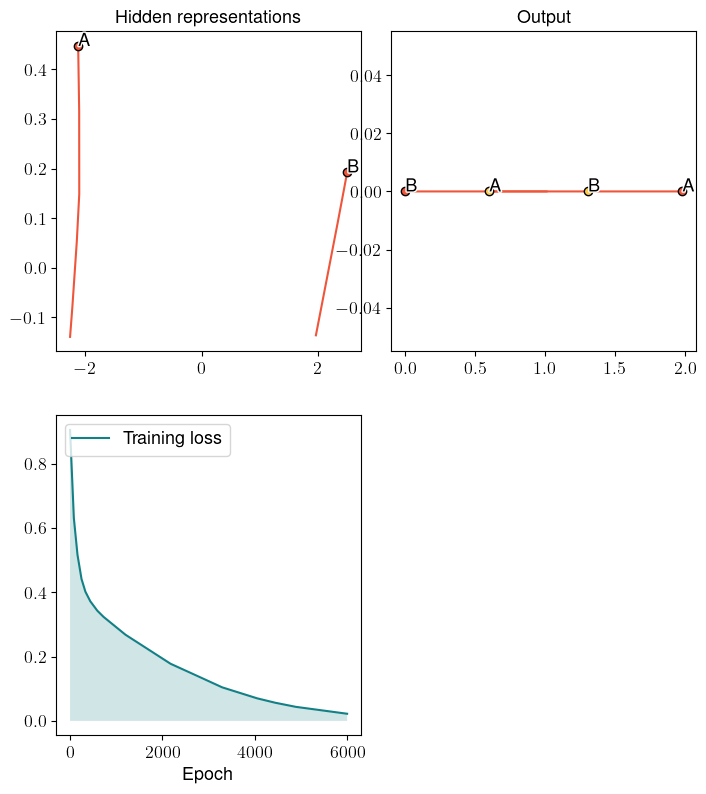

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [23]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = f"Epoch % {mod} == 0"
data_hid = data_hid.copy().query(query)
data_output = data_output.copy().query(query)

loss = compiler.trackers["loss"].get_trace().copy()
val_loss = loss.query(query).query("Dataset==0")[0].to_numpy()
train_loss = loss.groupby("Epoch").mean().query(query)
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()


animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid.query("Dataset != 0"), transform="PCA", plot_labels=True
        ),
        "Output": ActivationsAnimation(
            data_output.query("Dataset != 0"),
            transform="none",
            plot_labels=True,
            fixed_points=dict(zip(names, outputs)),
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                # "Validation loss": val_loss,
            },
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

In [24]:
h_A = [
    np.array(data.loc[epoch, 0, "A"])
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
h_B = [
    np.array(data.loc[epoch, 0, "B"])
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
y_A = [
    np.array(data.loc[epoch, 0, "A"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_B = [
    np.array(data.loc[epoch, 0, "B"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]

epochs = np.arange(0, len(h_A))

y_true_A, y_true_B = outputs[0], outputs[1]
dy2 = np.sum((y_true_B - y_true_A) ** 2)
h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)
y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)


h0, y0, w0, dy = h2[0], y2[0], w[0], dy2
print(f"h0: {h0}")
print(f"y0: {y0}")
print(f"w0: {w0}")
print(f"dy: {dy}")

epochs = epochs * mod

h0: 21.730819702148438
y0: 3.9276535511016846
w0: 5.3290195739369
dy: 0.5000000000000001


In [25]:
## Fit effective learning rates
eta_h_opt, eta_y_opt = simulate.optimize_eta(
    h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 100)
)

Loss: 0.4275779472825014


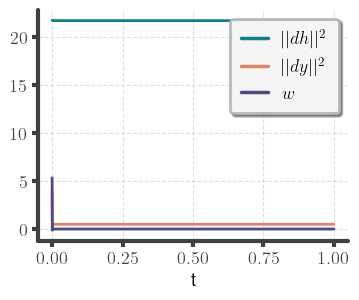

Loss: 52.670434154763626


/home/loek/projects/rnn/DNN/simulate.py:104: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/loek/projects/rnn/DNN/simulate.py:104: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


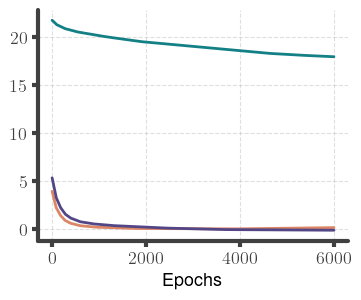

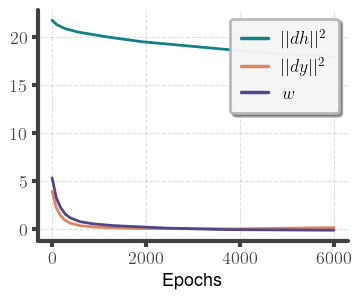

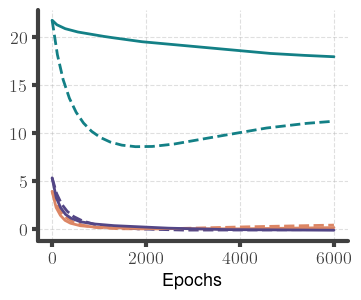

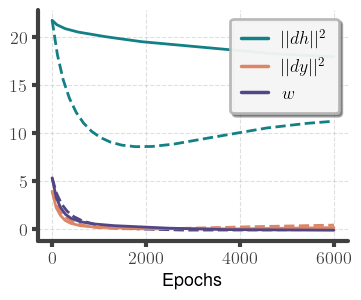

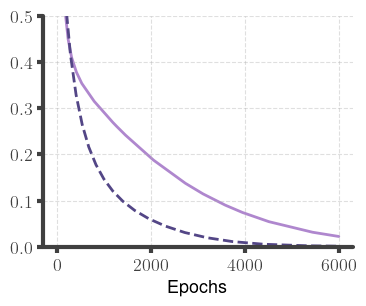

In [26]:
## Comparison
traj_path = "plots/2_points/trajectories/"

save = False

publication.set_color_mixed()

eta_h, eta_y = 0.01 * np.array([1, 4])

t_max = len(epochs)

sol = scipy.integrate.solve_ivp(
    simulate.der,
    [0, t_max],
    [h0, y0, w0],
    args=(eta_h, eta_y, dx2, dy2),
    dense_output=True,
)

t = np.linspace(0, t_max, len(epochs))
z = sol.sol(t)
t = t / t_max


fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(t, z[0], label="$||dh||^2$")
ax.plot(t, z[1], label="$||dy||^2$")
ax.plot(t, z[2], label="$w$")
ax.legend()
plt.xlabel("t")
if save:
    publication.plt_show(save_path=traj_path + "theory")
else:
    publication.plt_show()


eta_h, eta_y = eta_h_opt, eta_y_opt

t_max = len(epochs)

sol = scipy.integrate.solve_ivp(
    simulate.der,
    [0, t_max],
    [h0, y0, w0],
    args=(eta_h, eta_y, dx2, dy2),
    dense_output=True,
    method="Radau",
)

t = np.linspace(0, t_max, len(epochs))
z = sol.sol(t)

eta_y_mean_opt = simulate.optimize_eta_y_mean(z, train_loss, dy2, y0_mean)

loss_theory = simulate.loss(t, z, eta_y_mean_opt, dy2, y0_mean)

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(epochs, h2)
ax.plot(epochs, y2)
ax.plot(epochs, w)
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "experiment")
else:
    publication.plt_show()

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(epochs, h2, label="$||dh||^2$")
ax.plot(epochs, y2, label="$||dy||^2$")
ax.plot(epochs, w, label="$w$")
ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "experiment_legend")
else:
    publication.plt_show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(epochs, z[0], linestyle="--")
plt.plot(epochs, z[1], linestyle="--")
plt.plot(epochs, z[2], linestyle="--")
plt.gca().set_prop_cycle(None)
ax.plot(epochs, h2)
ax.plot(epochs, y2)
ax.plot(epochs, w)
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "compare")
else:
    publication.plt_show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(epochs, z[0], linestyle="--")
plt.plot(epochs, z[1], linestyle="--")
plt.plot(epochs, z[2], linestyle="--")
plt.gca().set_prop_cycle(None)
ax.plot(epochs, h2, label="$||dh||^2$")
ax.plot(epochs, y2, label="$||dy||^2$")
ax.plot(epochs, w, label="$w$")
ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "compare_legend")
else:
    publication.plt_show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.gca().set_prop_cycle(None)
ax.plot(0, 0)
ax.plot(0, 0)
ax.plot(t, loss_theory, label=r"loss (theory)", linestyle="--")
ax.plot(0, 0)
ax.plot(t, train_loss, label="loss", zorder=1)
# ax.legend()
plt.ylim(0, 0.5)
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "loss")
else:
    publication.plt_show()

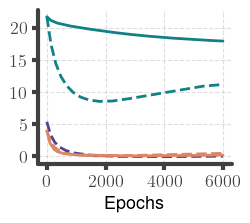

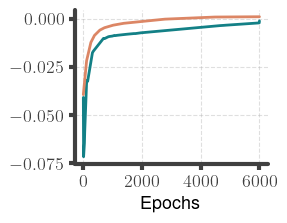

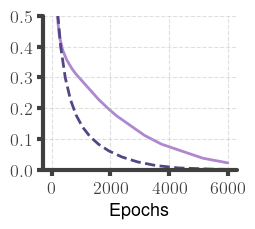

In [27]:
save = True
settings = "gain_1.6_sample_3"

# eta_h, eta_y = lr * np.array([lr, 1])
eta_h, eta_y = eta_h_opt, eta_y_opt


t_max = len(epochs)

sol = scipy.integrate.solve_ivp(
    simulate.der,
    [0, t_max],
    [h0, y0, w0],
    args=(eta_h, eta_y, dx2, dy2),
    dense_output=True,
)

t = np.linspace(0, t_max, len(epochs))
z = sol.sol(t)
t = epochs

dh = h2[1:] - h2[:-1]
dh = scipy.signal.convolve(dh, scipy.signal.windows.hann(25), mode="same")

# loss_theory = simulate.loss(t, z, eta_y_mean_opt, dy2, y0_mean)

figsize = (2.5, 2)

c = 1

fig, ax = plt.subplots(figsize=figsize)
plt.plot(t, c * z[0], linestyle="--")
plt.plot(t, z[1], linestyle="--")
plt.plot(t, z[2], linestyle="--")

# tau = 55
# C = 1 / 8
# s = np.sqrt(dx2 * dy2)
# u0 = y0 / dx2
# u = s * np.exp(2 * s * t / tau) / (np.exp(2 * s * t / tau) - 1 + s / u0)
# ax.plot(t, C * np.sqrt(u) * dx2, linestyle="--")
# ax.plot(t, u * dx2, linestyle="--")

plt.gca().set_prop_cycle(None)
ax.plot(t, c * h2, label="$||dh||^2$")
ax.plot(t, y2, label="$||dy||^2$")
# ax.plot(t, w, label="$w$")
# ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "ode/" + settings + ".png")
else:
    publication.plt_show()

## STIL PROPORTIAL WITHOUT FITTING
fig, ax = plt.subplots(figsize=figsize)
plt.gca().set_prop_cycle(None)
ax.plot(t[:-1], dh, label=r"$\frac{d}{dt}||dh||^2$")
# ax.plot(0, 0)
# ax.plot(t, -eta_h * 2 * w * dx2, label=r"$- 2||x_2-x_1||^2\frac{1}{\tau_h} w$")
ax.plot(t, -eta_h * w, label="$-C w$")
# ax.legend()
plt.ylim()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "dh/" + settings + ".png")
else:
    publication.plt_show()

fig, ax = plt.subplots(figsize=figsize)
plt.gca().set_prop_cycle(None)
ax.plot(0, 0)
ax.plot(0, 0)
ax.plot(t, loss_theory, label=r"loss (theory)", linestyle="--")
ax.plot(0, 0)
ax.plot(t, train_loss, label="loss", zorder=1)
# ax.legend()
plt.ylim(0, 0.5)
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "loss/" + settings + ".png")
else:
    publication.plt_show()

In [28]:
stop

NameError: name 'stop' is not defined

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org

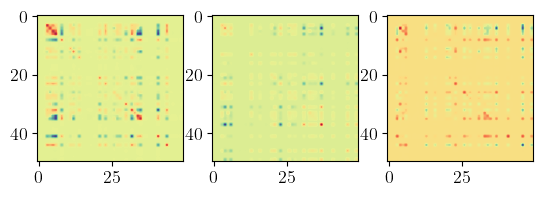

In [ ]:
from functorch import make_functional, vmap, vjp, jvp, jacrev

net = model.to(device)
fnet, params = make_functional(net)


def fnet_hidden(params, x):
    return fnet(params, x.unsqueeze(0))[1][int(L / 2)].squeeze(0)


def fnet_output(params, h):
    return fnet(params, h.unsqueeze(0))[0].squeeze(0)


x_1 = train_datasets[0][0][0]
x_2 = train_datasets[0][1][0]
h_1 = fnet_hidden(params, x_1)
h_2 = fnet_hidden(params, x_2)


def empirical_ntk(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = torch.vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = torch.vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]

    # Compute J(x1) @ J(x2).T
    result = torch.stack(
        [torch.einsum("Naf,Mbf->NMab", j1, j2) for j1, j2 in zip(jac1, jac2)]
    )
    result = result.sum(0)
    return result


# Plot eNTK
fig = plt.figure()

plt.subplot(1, 3, 1)
result = empirical_ntk(fnet_hidden, params, x_1, x_1)
plt.imshow(result[0][0].detach().numpy())

plt.subplot(1, 3, 2)
result = empirical_ntk(fnet_hidden, params, x_2, x_2)
plt.imshow(result[0][0].detach().numpy())

plt.subplot(1, 3, 3)
result = empirical_ntk(fnet_hidden, params, x_1, x_2)
plt.imshow(result[0][0].detach().numpy())

plt.show()